In [1]:
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import *
from sklearn.metrics import confusion_matrix, f1_score
from fastai.utils.mem import GPUMemTrace

In [2]:
import seaborn as sns
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
model_path = "."

train_df = tr 
valid_df = te
all_df = pd.concat((tr,te))

tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=2)]

data_lm = (TextList.from_df(all_df, model_path, cols="texts", processor=processor)
    .split_by_rand_pct(valid_pct = 0.2, seed = 1412)
    .label_for_lm()
    .databunch(bs=48))
data_lm.sanity_check()
data_lm.save('test_lm.pkl')
print(len(data_lm.train_ds))
print(len(data_lm.valid_ds))

config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)

trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

#train unfrozen
print("training unfrozen")
learn.unfreeze()
learn.fit_one_cycle(6, 1e-3, moms=(0.8, 0.7))

learn.save_encoder('CS_enc')

NameError: name 'tr' is not defined

In [ ]:
data_lm = load_data(model_path, "test_lm.pkl")
data_lm.sanity_check()

#classification data
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=20)]

data_cls = (ItemLists(model_path,train=TextList.from_df(tr, model_path, cols=["texts"], processor=processor),
                     valid=TextList.from_df(te, model_path, cols=["texts"], processor=processor))
    .label_from_df("labels")
    .databunch(bs=50)
    )
data_cls.sanity_check()
print(len(data_cls.vocab.itos))

#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
#load pretrained finetuned model
learn.load_encoder("CS_enc")

#train unfrozen
learn.freeze_to(-1)
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestmodel')])

learn.load("bestmodel")

#get predictions
probs, y_true, loss = learn.get_preds(ds_type = DatasetType.Valid, ordered=True, with_loss=True)
classes = learn.data.train_ds.classes
y_true = np.array([classes[i] for i in y_true.numpy()])
preds = np.array([classes[i] for i in probs.argmax(1).numpy()])
prob = probs.numpy()
loss = loss.numpy()

to_df = np.concatenate([y_true[:,None],preds[:,None],loss[:,None],prob],1)
probs_df = pd.DataFrame(to_df)
probs_df.columns = ["category","preds","loss"] + classes
probs_df["hit"] = (probs_df.category == probs_df.preds)
probs_df["texts"] = valid_df.texts
(y_true==preds).mean()

conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [3]:
from fastai.callbacks.tracker import TrackerCallback, EarlyStoppingCallback

In [4]:
class SaveEncoderCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'

    def jump_to_epoch(self, epoch:int)->None:
        try:
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if isinstance(current, Tensor): current = current.cpu()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save_encoder(f'{self.name}')

In [25]:
class ULMfit_for_predict():
    def __init__(self,
                 model_path):
        data_lm = load_data(model_path, "language_model_data.pkl")
        data_lm.sanity_check()
        cur_path = os.getcwd()
        os.chdir(model_path)
        tr = pd.read_csv('train.csv')
        te = pd.read_csv('test.csv')
        os.chdir(cur_path)
        #classification data
        tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
        processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
                    NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=20)]

        data_cls = (ItemLists(model_path,train=TextList.from_df(tr, model_path, cols=["texts"], processor=processor),
                             valid=TextList.from_df(te, model_path, cols=["texts"], processor=processor))
            .label_from_df("labels")
            .databunch(bs=50)
            )
        data_cls.sanity_check()
#         print(len(data_cls.vocab.itos))

        config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
                     output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
        trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

        self.learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
        self.learn.load("bestmodel")
        self.classes = self.learn.data.train_ds.classes
    def predict(self,
                raw_text):
        dictionary = {}
        x = self.learn.predict(raw_text)[2].numpy()
        for ind, tmp_class in enumerate(self.classes):
            dictionary[tmp_class] = x[ind]
        return dictionary
    
class ULMfit_model():
    # to train using ULMfit
    # 1. Fine-tuning the language model is needed
    # 2. Train the classifier
    def __init__(self,
                 data_for_lm, 
                 model_path: '(str) locate to the folder dont specify in any extension'):
        self.model_path = model_path
        self.tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
        self.processor = [TokenizeProcessor(tokenizer=self.tt, chunksize=10000, mark_fields=False),
                    NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=2)]
        
        self.data_lm = (TextList.from_df(data_for_lm, self.model_path, cols="texts", processor=self.processor)
            .split_by_rand_pct(valid_pct = 0.2, seed = 123)
            .label_for_lm()
            .databunch(bs=48))
        self.data_lm.save('language_model_data.pkl')
        self.data_lm.sanity_check()
        print(f'number of training samples: {len(self.data_lm.train_ds)}')
        print(f'number of test samples: {len(self.data_lm.valid_ds)}')
        self.learn = None
        
    def fit_lm(self):
        config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)

        trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

        self.learn = language_model_learner(self.data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

        #load pretrained models
        self.learn.load_pretrained(**_THWIKI_LSTM)

        #train unfrozen
        print("training unfrozen")
#         with GPUMemTrace():
        self.learn.unfreeze()

        self.learn.fit_one_cycle(3, 1e-3, moms=(0.8, 0.7),
                                 callbacks=[SaveEncoderCallback(self.learn, every='improvement', monitor='accuracy', name='LM'),
                                            EarlyStoppingCallback(self.learn, min_delta=0.0, patience=5)])
    def fit_classifier(self,
                       tr,
                       te):
        self.processor = [TokenizeProcessor(tokenizer=self.tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=self.data_lm.vocab, max_vocab=60000, min_freq=20)]

        self.data_cls = (ItemLists(self.model_path,train=TextList.from_df(tr, self.model_path, cols=["texts"], processor=self.processor),
                             valid=TextList.from_df(te, self.model_path, cols=["texts"], processor=self.processor))
            .label_from_df("labels")
            .databunch(bs=50)
            )
        tr.to_csv(os.path.join(self.model_path, 'train.csv'), index=False)
        te.to_csv(os.path.join(self.model_path, 'test.csv'), index=False)
#         self.data_cls.save('data_cls.pkl')
        self.data_cls.sanity_check()
        print(f'total vocab size: {len(self.data_cls.vocab.itos)}')

        #model
        config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
                     output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
        trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

        self.learn = text_classifier_learner(self.data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
        #load pretrained finetuned model
        self.learn.load_encoder("./LM")

        #train unfrozen
#         with GPUMemTrace():
        self.learn.freeze_to(-1)
        self.learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))
        self.learn.freeze_to(-2)
        self.learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))
        self.learn.freeze_to(-3)
        self.learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))
        self.learn.unfreeze()
        self.learn.fit_one_cycle(3, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7),
                           callbacks=[SaveModelCallback(self.learn, every='improvement', monitor='accuracy', name='bestmodel'),
                                      EarlyStoppingCallback(self.learn, min_delta=0.0, patience=5)])

        self.learn.load("bestmodel")

        #get predictions
        probs, y_true, loss = self.learn.get_preds(ds_type = DatasetType.Valid, ordered=True, with_loss=True)
        classes = self.learn.data.train_ds.classes
        y_true = np.array([classes[i] for i in y_true.numpy()])
        preds = np.array([classes[i] for i in probs.argmax(1).numpy()])
        prob = probs.numpy()
        loss = loss.numpy()

        to_df = np.concatenate([y_true[:,None],preds[:,None],loss[:,None],prob],1)
        probs_df = pd.DataFrame(to_df)
        probs_df.columns = ["category","preds","loss"] + classes
        probs_df["hit"] = (probs_df.category == probs_df.preds)
        probs_df["texts"] = te.texts
        (y_true==preds).mean()

        conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
        sns.heatmap(conf_mat, annot=True, fmt="d",
                    xticklabels=classes, yticklabels=classes)
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()
        
        f1s = f1_score(probs_df.category, probs_df.preds, average=None)
        print(f'f1-scores for each class: {f1s}')
        print(f'Weighted avg f1-score: {f1_score(probs_df.category, probs_df.preds, average="weighted")}, Unweighted avf f1-score: {np.mean(f1s)}')
        

In [4]:
os.chdir('..')
os.getcwd()

'/home/kamin'

In [5]:
tr = pd.read_csv('train_RS_123.csv')
# tr.head()
te = pd.read_csv('test_RS_123.csv')
# te.head()
tr = tr.dropna().reset_index(drop=True)
te = te.dropna().reset_index(drop=True)

In [6]:
with open('BAY_pantip.json', 'r', encoding='utf8') as f:
    data = json.load(f)

In [7]:
tmp = []
for i in data:
    i = data[i].strip()
    if i != '':
        i = i.split('\n')
        for j in i:
            j = j.strip()
            if j != '':
                tmp.append(j)

In [8]:
len(tmp)

121111

In [9]:
for ind, i in enumerate(tmp):
    print(i)
    if ind > 10:
        break

จ่ายเงินเฟิสช้อยขาด
จ่ายเฟิร์สช้อยขาดไป 60 บาท เป็นอะไรมั้ยค่ะ
โดนดอกเบี้ยสิจ๊ะ นับตั้งแต่วันที่รูดนะไม่ใช่วันที่จ่ายแล้วขาด60บาท
รีบจ่ายให้ครบก่อนเกินกำหนด ไม่งั้นจะโดนคิดดอกเบี้ย
โดนดอกเบี้ยสิจ๊ะ นับตั้งแต่วันที่รูดนะไม่ใช่วันที่จ่ายแล้วขาด60บาท
รีบไปจ่ายเลยจ้าไม่งั้นโดนดอกเพื่ม
ไม่เป็นไร เพราะ สมมุติจ่ายขาดไป 60 บาท จากยอดรูดทั้งหมดในรอบบิลนั้น 10,000 บาท จะโดนคิดดอก18% ทุกรายการจากยอด 10,000 ไม่ใช่ 60 บาท
ไม่งงนะ
สวัสดีครับ คุณสมาชิกหมายเลข 4217582
อย่างไรแล้วทางเจ้าหน้าที่ขอทราบชื่อ - นามสกุล เบอร์ติดต่อ พร้อมแนบ link กระทู้นี้ให้เจ้าหน้าทางหลังไมค์ด้วยครับ เจ้าหน้าที่จะได้ตรวจสอบข้อมูล และ แจ้งรายละเอียดให้ทราบโดยตรง
ขอบคุณครับ
กดแอพธนาคารในโทรศัพท์แล้วกดจ่ายเพิ่มเข้าไปอีก 60 บาทค่ะไม่งั้นบิลหน้มีดอกเบี้ยโผล่มาให้ตกใจอีกนะคะ


In [10]:
tmp = list(set(tmp))

In [11]:
tmp = [i.strip() for i in tmp if len(i.strip()) >= 15]

In [12]:
len(tmp)

100522

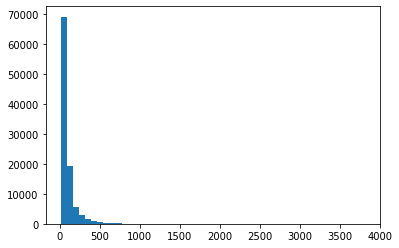

In [13]:
x = [len(i) for i in tmp]
plt.hist(x,50)
plt.show()

In [14]:
np.mean(x)

93.92135055012832

In [15]:
y = sorted(x, reverse=True)
y = y[int(len(y)*0.01):]

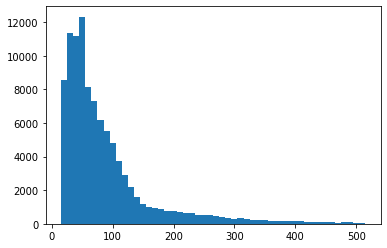

In [16]:
plt.hist(y,50)
plt.show()

In [17]:
data_for_lm = pd.DataFrame({'texts': tmp})

In [18]:
os.chdir('Thai_NLP')

In [19]:
from ulmfit import ULMfit_for_predict, ULMfit_model

In [20]:
from tqdm import trange

In [21]:
os.getcwd()
os.chdir('..')

In [25]:
model_path = './Untitled Folder 1'
model = ULMfit_model(tr.iloc[:100], model_path)

number of training samples: 80
number of test samples: 20


In [26]:
model.fit_lm()

training unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,4.617828,3.285137,0.293452,00:08
1,4.565338,2.688225,0.447619,00:08
2,4.302119,2.575235,0.470238,00:08


/home/kamin/.virtualenv/dev36/lib/python3.6/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


Better model found at epoch 0 with accuracy value: 0.2934523820877075.


/home/kamin/.virtualenv/dev36/lib/python3.6/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


Better model found at epoch 1 with accuracy value: 0.4476190507411957.


/home/kamin/.virtualenv/dev36/lib/python3.6/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


Better model found at epoch 2 with accuracy value: 0.4702380895614624.


/home/kamin/.virtualenv/dev36/lib/python3.6/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


total vocab size: 112


epoch,train_loss,valid_loss,accuracy,time
0,1.246212,1.063404,0.460000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.225631,1.034198,0.490000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.978192,1.046586,0.480000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.952645,1.039602,0.490000,00:09
1,0.925124,1.031824,0.470000,00:09
2,0.880903,1.029545,0.440000,00:09


Better model found at epoch 0 with accuracy value: 0.49000000953674316.


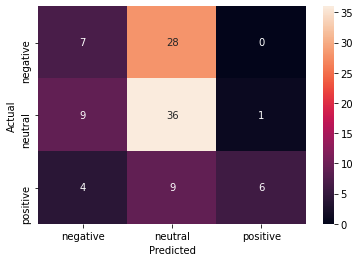

f1-scores for each class: [0.254545 0.605042 0.461538]
Weighted avg f1-score: 0.45510254451430926, Unweighted avf f1-score: 0.44037531096354626


In [27]:
model.fit_classifier(tr.iloc[:100],te.iloc[:100])

In [28]:
del model

In [29]:
x = ULMfit_for_predict(model_path)

/home/kamin/.virtualenv/dev36/lib/python3.6/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [37]:
%%time
for i in trange(10000):
    x.predict(tmp[i])

100%|██████████| 10000/10000 [31:47<00:00,  5.24it/s] 

CPU times: user 1h 52min 29s, sys: 51.2 s, total: 1h 53min 20s
Wall time: 31min 47s


In [31]:
os.chdir('Thai_NLP')
from text_classification import Text_classification_for_prediction

In [32]:
tc = Text_classification_for_prediction(
    path_to_tfxidf = 'models_for_real_deployment/tf-idf_encoder.joblib',
    model_path= 'models_for_real_deployment/text_classification',
    engine = "linear_classifier")

loading logistic regression model


In [38]:
%%time
for i in trange(10000):
    tc.predict(tmp[i])

100%|██████████| 10000/10000 [00:10<00:00, 913.47it/s]

CPU times: user 11.2 s, sys: 70.6 ms, total: 11.3 s
Wall time: 10.9 s


In [33]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import BertTokenizer, TFBertModel, BertConfig, BertModel, TFBertForPreTraining, BertForPreTraining
import sentencepiece as spm

VOCAB_DIR = '../th_wiki_bpe/th.wiki.bpe.op25000.vocab'
MODEL_DIR = '../th_wiki_bpe/th.wiki.bpe.op25000.model'

class InputFeatures():
    def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id):
        self.input_ids = input_ids
        self.attention_mask = input_mask
        self.token_type_ids = segment_ids
        self.label_id = label_id

class ThaiTokenizer():
    def __init__(self,
               model_dir,
               vocab_dir):
        #<unk> ==> ind = 4
        self.dictionary = {}
        with open(vocab_dir, 'r', encoding='utf8') as f:
            for ind,i in enumerate(f):
                self.dictionary[i.split()[0]] = ind
        self.sp = spm.SentencePieceProcessor(model_file=model_dir)
    def tokenize(self,
                text):
        return self.sp.encode(text, out_type=str)
    def convert_tokens_to_ids(self,
                            tokens):
        tmp = []
        for i in tokens:
            try:
                tmp.append(self.dictionary[i])
            except:
                tmp.append(4)
        return tmp
    

class Text_classification_examples():
    def __init__(self, tokenizer, max_len, ulabels):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.ulabels = ulabels

    def preprocess(self,
                  texts,
                  labels=None):
#         print(labels)
        if labels is not None:
            assert len(texts) == len(labels), 'len(texts) != len(labels)'
        dataset_dict = {
            "input_ids": [],
            "token_type_ids": [],
            "attention_mask": [],
            "label_onehot": [],
        }
        for i in range(len(texts)):
            if labels is not None:
                feature_obj = self.convert_single_example(i, texts[i], labels[i])
            else:
                feature_obj = self.convert_single_example(i, texts[i])
            for feature in dataset_dict:
                if feature == 'label_onehot':
                    if labels is not None:
                        dataset_dict['label_onehot'].append(getattr(feature_obj, 'label_id'))
                    else:
                        dataset_dict['label_onehot'].append(None)
                else:
                    dataset_dict[feature].append(getattr(feature_obj, feature))
        return [dataset_dict["input_ids"], dataset_dict["token_type_ids"], dataset_dict["attention_mask"]], [dataset_dict["label_onehot"]]

    def convert_single_example(self, 
                             ex_index, 
                             text_a, 
                             label=None):
        """Converts a single `InputExample` into a single `InputFeatures`."""

        tokens_a = self.tokenizer.tokenize(text_a)
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > self.max_len - 2:
            tokens_a = tokens_a[:(self.max_len - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0     0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)


        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < self.max_len:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)
        # print(len(input_ids))
        # print(len(input_mask))
        # print(len(segment_ids))
        assert len(input_ids) == self.max_len
        assert len(input_mask) == self.max_len
        assert len(segment_ids) == self.max_len
        if label is not None:
            label_id = self.ulabels[label]
        else:
            label_id = -1
#         if ex_index < 5:
#             print("*** Example ***")
#             print("tokens: %s" % " ".join(tokens))
#             print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
#             print("input_mask: %s" % " ".join([str(x) for x in input_mask]))
#             print("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
#             print("label: %s (id = %d)" % (label, label_id))

        feature = InputFeatures(
            input_ids=input_ids,
            input_mask=input_mask,
            segment_ids=segment_ids,
            label_id=label_id)
        return feature
    
tokenizer = ThaiTokenizer(MODEL_DIR, VOCAB_DIR)
max_len = 128
ulabels = {'negative': 0, 'neutral': 1, 'positive': 2}

data_preb = Text_classification_examples(tokenizer, max_len, ulabels)

In [73]:
# X,Y =data_preb.preprocess(tmp[:10000])#, tr['labels'])

In [34]:
config = BertConfig.from_json_file('../bert_base_th/bert_config.json')
# encoder = BertForPreTraining.from_pretrained('./bert_base_th/model.ckpt',from_tf=True, config=config)
# encoder = BertForPreTraining.from_pretrained('./BERTLM_fold1.pt', config=config)
encoder = torch.load('../BERTLM_fold1.pt')
class bert_for_classification(nn.Module):
    def __init__(
        self,
        BertForPreTraining_model: '(transformers obj)',
        unique_labels: '(dict[str:int]) the keys are unique labels, the values are integers mapping to class index (from 0 to num_unique_labels - 1)',
        max_len: '(int) max length of the input sequences'):
        super().__init__()
        self.BertForPreTraining_model = BertForPreTraining_model
        self.unique_labels = unique_labels
        self.max_len = max_len
        self.linear1 = torch.nn.Linear(768, 2)
#         self.linear1 = torch.nn.Linear(768, 256)
        self.flatten = torch.nn.Flatten()
        
        self.out = torch.nn.Linear(256, len(self.unique_labels))
        
    def forward(self, inputs):
        input_ids = inputs[0]
        token_type_ids = inputs[1]
        attention_mask = inputs[2]
        x = self.BertForPreTraining_model.bert(input_ids, token_type_ids, attention_mask)[0]
        x = F.gelu((self.linear1(x)))
        x = self.flatten(x)
        return self.out(x)
#.220
BERT = bert_for_classification(BertForPreTraining_model= encoder, 
                               unique_labels= {'negative': 0, 'neutral': 1, 'positive': 2}, 
                               max_len=128)

In [35]:
from tqdm import trange
BS = 32
remainder_te = False
num_te = len(tmp)//BS
if len(tmp)%BS != 0:
    remainder_te = True
NUM_EPOCH = 1

In [36]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [39]:
%%time

for i in range(NUM_EPOCH):
    print(f'now is epoch: {i}')
    with torch.no_grad():
        for j in trange(num_te):
            data, _ = data_preb.preprocess(tmp[BS*j: BS*(j+1)])
            data1 = torch.tensor(data[0],dtype=torch.int64).to(device)
            data2 = torch.tensor(data[1],dtype=torch.int64).to(device)
            data3 = torch.tensor(data[2],dtype=torch.int64).to(device)
#             target = y_te[BS*j: BS*(j+1)].to(device)

            out = BERT([data1, data2, data3])
#             loss = criterion(out, target)
#             tmp_loss += loss.item()
    #         loss.backward()
    #         optimizer.step()

        if remainder_te:
            data, _ = data_preb.preprocess(tmp[BS*(j+1):])
            data1 = torch.tensor(data[0],dtype=torch.int64).to(device)
            data2 = torch.tensor(data[1],dtype=torch.int64).to(device)
            data3 = torch.tensor(data[2],dtype=torch.int64).to(device)
#             target = y[BS*(j+1):].to(device)

            out = BERT([data1, data2, data3])
    #         target = torch.max(target, 1)
    #         out = torch.max(out, 1)
#             loss = criterion(out, target)
#             tmp_loss += loss.item()
    #         loss.backward()
    #         optimizer.step()


  0%|          | 0/3141 [00:00<?, ?it/s]

now is epoch: 0


100%|██████████| 3141/3141 [2:19:25<00:00,  2.66s/it]  


CPU times: user 9h 9min 45s, sys: 28.6 s, total: 9h 10min 14s
Wall time: 2h 19min 26s
